<a href="https://colab.research.google.com/github/Katiaaaa/FakeNewsDetection_BERT/blob/main/first_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


In [ ]:
!pip install -q tensorflow-text

     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 588.3 MB 14 kB/s 
     |████████████████████████████████| 6.0 MB 44.3 MB/s 
     |████████████████████████████████| 1.7 MB 43.0 MB/s 
     |████████████████████████████████| 439 kB 53.8 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_true=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/news/True.csv')
df_fake=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/news/Fake.csv')
df_true["label"] = "real"
df_fake["label"] = "fake"

In [ ]:
frames = [df_true,df_fake]
df = pd.concat(frames)
df

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,12/31/2017,real
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,12/29/2017,real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,12/31/2017,real
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,12/30/2017,real
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,12/29/2017,real
...,...,...,...,...,...
23445,COORDINATED? Yet Another Hack Reporter Claims ...,A coordinated effort to spew anti-Trump propag...,politics,12/31/2017,fake
23446,BARBRA STREISAND Gives Up On Dream Of Impeachi...,Barbra Streisand was an Obama sycophant and on...,politics,12/31/2017,fake
23447,WATCH: SENATOR LINDSEY GRAHAM DROPS BOMBSHELL…...,Everyone suspected the sketchy Steele Dossier ...,politics,12/31/2017,fake
23448,BARBRA STREISAND Gives Up On Dream Of Impeachi...,Barbra Streisand was an Obama sycophant and on...,left-news,12/31/2017,fake


In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df['label']=df['label'].apply(lambda x: 1 if x=='fake' else 0)
labels=df.label
labels

11128    0
11494    1
11097    1
7492     1
12524    0
        ..
16006    0
6513     0
10044    1
12261    1
16467    1
Name: label, Length: 44867, dtype: int64

Cleaning data

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
column_n = ['title', 'text','subject','date','label']
remove_c = ['subject']
categorical_features = []
target_col = ['label']
text_f = ['title', 'text']

# Clean Datasets
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from collections import Counter

ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)


# drop row with shirt text
def null_process(feature_df):
    for col in text_f:
        if len(feature_df[col])<7:
          feature_df = feature_df.drop(feature_df.index(col))
    return feature_df

def clean_dataset(df):
    #impute null values
    df = null_process(df)
    return df
    
# Cleaning text from unused characters
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  # removing urls
    text = str(text).replace(r'[^\.\w\s]', ' ')  # remove everything but characters and punctuation
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ')
    text = text.lower().strip()
    return text


def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    text = ' '.join([word for word in wordlist if word not in stopwords_dict])
    text = [ps.stem(word) for word in wordlist if not word in stopwords_dict]
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return  text


#https://www.thepythoncode.com/article/fake-news-classification-in-python

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
df1 = df.copy()

In [ ]:
df1['date']= df1['date'].astype('datetime64[ns]')
df1

,title,text,subject,date,label
11128,Poll: Trump in lead at 40.6 percent,DES MOINES (Reuters) - Republican front-runner...,politicsNews,2016-01-22,0
11494,TEACHERS GIVE STUDENTS OUTRAGEOUS Religious Ed...,The indoctrination of our youth is happening a...,left-news,2016-02-23,1
11097,Bette Midler Uses Cruz And Trump’s Own Insults...,Bette Midler has been busy sticking it to the ...,News,2016-02-17,1
7492,WATCH: KELLYANNE CONWAY Gives Dreaded Answer T...,ABC host George Stephanopoulos sat down with K...,left-news,2017-08-06,1
12524,Leading French conservative quits party after ...,PARIS (Reuters) - Right-wing heavyweight Xavie...,worldnews,2017-12-11,0
...,...,...,...,...,...
16006,Belgian prosecutors charge two over foiled att...,BRUSSELS (Reuters) - Belgian federal prosecuto...,worldnews,2017-10-31,0
6513,Trump Organization says it has no plans to bui...,BUENOS AIRES (Reuters) - The Trump Organizatio...,politicsNews,2017-01-05,0
10044,WATCH HILARIOUSLY AWKWARD Moment Between Rick ...,Franken asked Perry if he enjoyed a meeting th...,Government News,2017-01-20,1
12261,Secret Service Laptop Reportedly ‘Stolen’ had ...,21st Century Wire says A laptop was reportedly...,Middle-east,2017-03-17,1


In [ ]:
clean_dataset(df1)
# apply preprocessing on text through apply method by calling the function nltk_preprocess
df1["text"] = df1.text.apply(clean_text)
df1["text"] = df1.text.apply(nltk_preprocess)
# apply preprocessing on title through apply method by calling the function nltk_preprocess
df1["title"] = df1.title.apply(clean_text)
df1["title"] = df1.title.apply(nltk_preprocess)
df1

,title,text,subject,date,label
11128,poll trump lead 406 percent,de moines reuters republican frontrunner candi...,politicsNews,2016-01-22,0
11494,teacher give student outrageous religious ed a...,indoctrination youth happening every level alm...,left-news,2016-02-23,1
11097,bette midler us cruz trump insult deliciously ...,bette midler busy sticking gop clown car candi...,News,2016-02-17,1
7492,watch kellyanne conway give dreaded answer lib...,abc host george stephanopoulos sat kellyanne c...,left-news,2017-08-06,1
12524,leading french conservative quits party right ...,paris reuters rightwing heavyweight xavier ber...,worldnews,2017-12-11,0
...,...,...,...,...,...
16006,belgian prosecutor charge two foiled attack hi...,brussels reuters belgian federal prosecutor sa...,worldnews,2017-10-31,0
6513,trump organization say plan build buenos aire ...,buenos aire reuters trump organization plan bu...,politicsNews,2017-01-05,0
10044,watch hilariously awkward moment rick perry al...,franken asked perry enjoyed meeting recently o...,Government News,2017-01-20,1
12261,secret service laptop reportedly stolen trump ...,21st century wire say laptop reportedly stolen...,Middle-east,2017-03-17,1


In [ ]:
df1.to_csv('/content/drive/MyDrive/ColabNotebooks/news/clean_data.csv',sep='\t')

In [ ]:
df_clean=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/news/clean_data.csv', sep='\t')
df_clean

,Unnamed: 0,title,text,subject,date,label
0,11128,poll trump lead 406 percent,de moines reuters republican frontrunner candi...,politicsNews,2016-01-22,0
1,11494,teacher give student outrageous religious ed a...,indoctrination youth happening every level alm...,left-news,2016-02-23,1
2,11097,bette midler us cruz trump insult deliciously ...,bette midler busy sticking gop clown car candi...,News,2016-02-17,1
3,7492,watch kellyanne conway give dreaded answer lib...,abc host george stephanopoulos sat kellyanne c...,left-news,2017-08-06,1
4,12524,leading french conservative quits party right ...,paris reuters rightwing heavyweight xavier ber...,worldnews,2017-12-11,0
...,...,...,...,...,...,...
44862,16006,belgian prosecutor charge two foiled attack hi...,brussels reuters belgian federal prosecutor sa...,worldnews,2017-10-31,0
44863,6513,trump organization say plan build buenos aire ...,buenos aire reuters trump organization plan bu...,politicsNews,2017-01-05,0
44864,10044,watch hilariously awkward moment rick perry al...,franken asked perry enjoyed meeting recently o...,Government News,2017-01-20,1
44865,12261,secret service laptop reportedly stolen trump ...,21st century wire say laptop reportedly stolen...,Middle-east,2017-03-17,1


Training model

In [ ]:
df_clean["label"].value_counts()

1    23450
0    21417
Name: label, dtype: int64

In [ ]:
df_clean.dtypes

Unnamed: 0     int64
title         object
text          object
subject       object
date          object
label          int64
dtype: object

In [ ]:
#Split the dataset
#test_size=0.2, random_state=7, stratify=df_clean['label']
x_train,x_test,y_train,y_test=train_test_split(df_clean['title'], df_clean['label'],test_size=0.9, random_state=7 )

In [ ]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [ ]:
bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

e = get_sentence_embeding([
    "TRUMP ARRIVES IN MOBILE, ALABAMA TO SAY THANKS", 
    "Trump says Russia probe will be fair, but timeline unclear: NYT",
    "Virginia officials postpone lottery drawing to decide tied statehouse election",
    "Trump on Twitter (Dec 26) - Hillary Clinton, Tax Cut Bill"]
)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[1]],[e[3]])

array([[0.9665755]], dtype=float32)

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='title')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
  2/141 [..............................] - ETA: 31:54 - loss: 0.7331 - accuracy: 0.5156 - precision: 0.4571 - recall: 0.5714

In [ ]:
model.evaluate(x_test, y_test)

1376/1376 [==============================] - 445s 323ms/step - loss: 0.4778 - accuracy: 0.8263 - precision: 0.8545 - recall: 0.8048


[0.4777644872665405,
 0.8262766599655151,
 0.8545194268226624,
 0.8048324584960938]

In [ ]:
y_pred = model.predict(x_test)
y_pred = y_pred.flatten()

1376/1376 [==============================] - 445s 323ms/step


In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)

Accuracy

In [ ]:
#DataFlair - Initialize a PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(x_train,y_train)
#DataFlair - Predict on the test set and calculate accuracy
y_pred=pac.predict(x_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

#Build confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[17837,  3153],
       [ 4491, 18520]])

Text(33.0, 0.5, 'Truth')

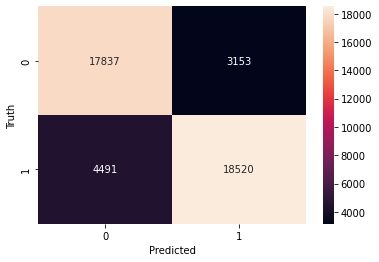

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82     20990
           1       0.85      0.80      0.83     23011

    accuracy                           0.83     44001
   macro avg       0.83      0.83      0.83     44001
weighted avg       0.83      0.83      0.83     44001



Inference

In [ ]:
reviews = [
    "TRUMP ARRIVES IN MOBILE, ALABAMA TO SAY THANKS", 
    "Trump says Russia probe will be fair, but timeline unclear: NYT",
    "Virginia officials postpone lottery drawing to decide tied statehouse election",
    "Trump on Twitter (Dec 26) - Hillary Clinton, Tax Cut Bill"]
model.predict(reviews)

1/1 [==============================] - 1s 743ms/step


array([[0.5906631 ],
       [0.49927577],
       [0.08880474],
       [0.7777535 ]], dtype=float32)